In [1]:
import json, gzip
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

file = "Home_and_Kitchen.jsonl.gz"
with gzip.open(file, "rt", encoding="utf-8") as fp:
    for line in fp:
        obj = json.loads(line)
        print(obj)
        break

{'rating': 1.0, 'title': 'Received Used & scratched item! Purchased new!', 'text': 'Livid.  Once again received an obviously used item that has food on it & scratches. I purchased this new!!  Pics not loading rn. Will add them later. Disgusted.', 'images': [], 'asin': 'B007WQ9YNO', 'parent_asin': 'B09XWYG6X1', 'user_id': 'AFKZENTNBQ7A7V7UXW5JJI6UGRYQ', 'timestamp': 1677373409298, 'helpful_vote': 1, 'verified_purchase': True}


Part 2: Exploratory Data Analysis

In [2]:
reviews = []
with gzip.open(file, "rt", encoding="utf-8") as fp:
    for i, line in enumerate(fp):
        reviews.append(json.loads(line))
        if i >= 5000000:
            break

df = pd.DataFrame(reviews)
df.head()


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,1.0,Received Used & scratched item! Purchased new!,Livid. Once again received an obviously used ...,[],B007WQ9YNO,B09XWYG6X1,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1677373409298,1,True
1,5.0,Excellent for moving & storage & floods!,I purchased these for multiple reasons. The ma...,[],B09H2VJW6K,B0BXDLF8TW,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1672043410846,0,True
2,2.0,Lid very loose- needs a gasket imo. Small base.,[[VIDEOID:c87e962bc893a948856b0f1b285ce6cc]] I...,[{'small_image_url': 'https://m.media-amazon.c...,B07RL297VR,B09G2PW8ZG,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1653447296788,0,True
3,5.0,Best purchase ever!,If you live at a higher elevation like me (5k ...,[{'small_image_url': 'https://m.media-amazon.c...,B09CQF4SWV,B08CSZDXZY,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1651855096178,0,True
4,5.0,Excellent for yarn!,I use these to store yarn. They easily hold 12...,[{'small_image_url': 'https://images-na.ssl-im...,B003U6A3EY,B0C6V27S6N,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1589934525940,1,True


In [3]:
print(f"Loaded {len(df):,} reviews")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nRating distribution:")
print(df['rating'].value_counts().sort_index())

Loaded 5,000,001 reviews

Columns: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']

Data types:
rating               float64
title                 object
text                  object
images                object
asin                  object
parent_asin           object
user_id               object
timestamp              int64
helpful_vote           int64
verified_purchase       bool
dtype: object

Missing values:
rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64

Rating distribution:
rating
1.0     361660
2.0     219631
3.0     355427
4.0     628002
5.0    3435281
Name: count, dtype: int64


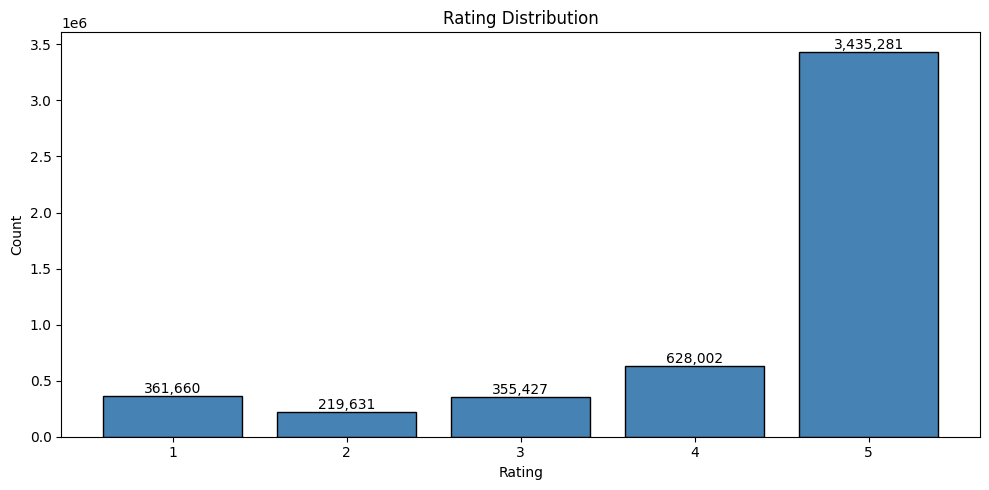

First 100k reviews:
rating
1.0    0.05430
2.0    0.03639
3.0    0.06860
4.0    0.14484
5.0    0.69587
Name: proportion, dtype: float64

Last 100k reviews:
rating
1.0    0.07389
2.0    0.04215
3.0    0.06856
4.0    0.11245
5.0    0.70295
Name: proportion, dtype: float64


In [4]:
plt.figure(figsize=(10, 5))
rating_counts = df['rating'].value_counts().sort_index()
plt.bar(rating_counts.index, rating_counts.values, color='steelblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')
for i, v in zip(rating_counts.index, rating_counts.values):
    plt.text(i, v, f'{v:,}', ha='center', va='bottom')
plt.tight_layout()
plt.show()


print("First 100k reviews:")
df_early = pd.DataFrame(reviews[:100000])
print(df_early['rating'].value_counts(normalize=True).sort_index())

print("\nLast 100k reviews:")
df_late = pd.DataFrame(reviews[-100000:])
print(df_late['rating'].value_counts(normalize=True).sort_index())


Review length stats (words):
count    5.000001e+06
mean     3.921665e+01
std      5.643618e+01
min      0.000000e+00
25%      1.000000e+01
50%      2.300000e+01
75%      4.700000e+01
max      4.023000e+03
Name: text_length, dtype: float64


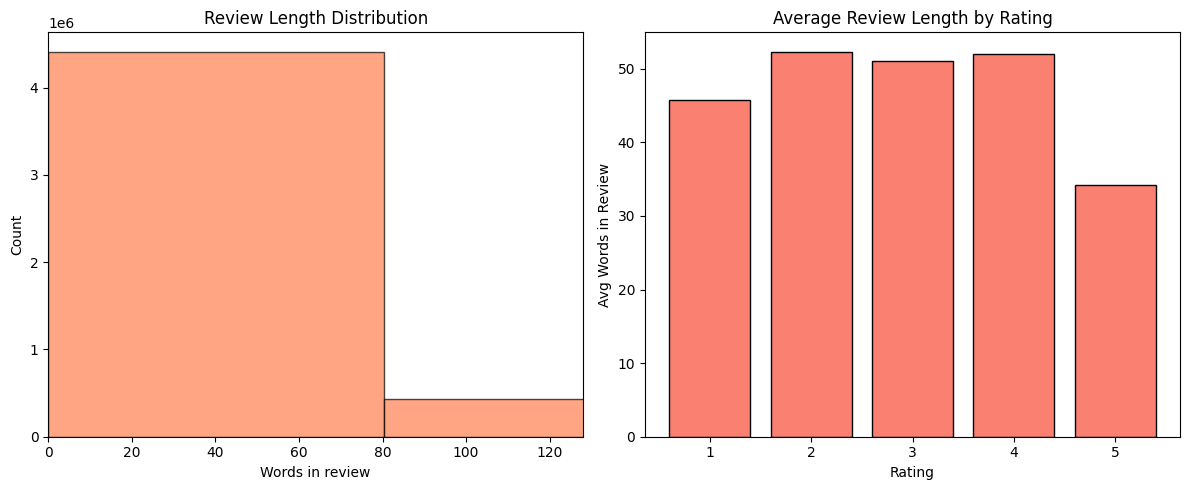


655,389 unique users
1,420,467 unique products
Avg reviews per user: 7.63
Avg reviews per product: 3.52

Users with only 1 review: 144,145 (22.0%)
Products with only 1 review: 836,759 (58.9%)

Top 10 most reviewed products:
asin
B013R3Q7B2    5199
B00FLYWNYQ    4915
B001EYHAGS    3439
B07547PTX8    3229
B01CX1RIMQ    3160
B00DDXWFY0    2733
B005YR0F40    2536
B00BC0SPIQ    2533
B002IT6E6A    2375
B00ZOH2J5I    2243
Name: count, dtype: int64

Reviews by year:
year
2000        48
2001        89
2002       158
2003       299
2004       385
2005       720
2006      1240
2007      2947
2008      3712
2009      5323
2010     10149
2011     19043
2012     35846
2013     96172
2014    172281
2015    278933
2016    380659
2017    417141
2018    483036
2019    651736
2020    770683
2021    808739
2022    694010
2023    166652
Name: count, dtype: int64


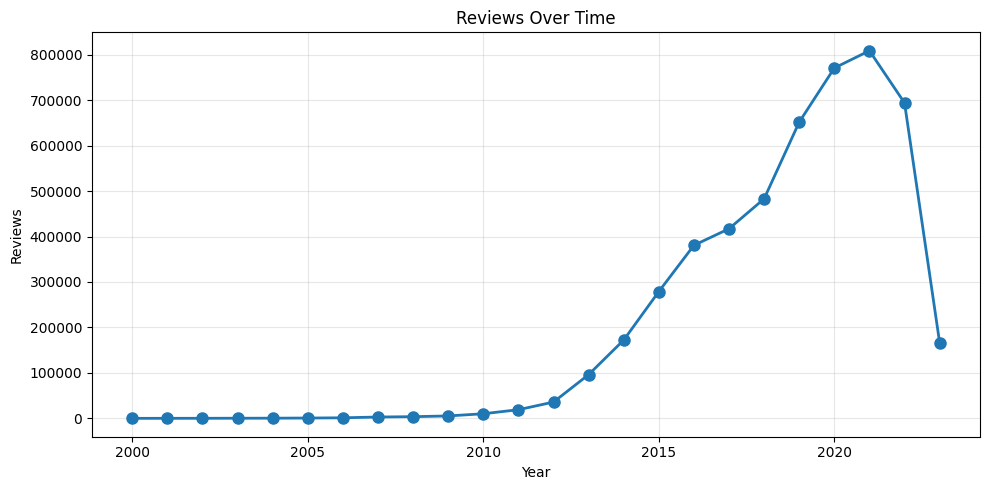


Helpful votes by rating:
rating
1.0    2.38
2.0    1.36
3.0    1.25
4.0    1.30
5.0    1.01
Name: helpful_vote, dtype: float64


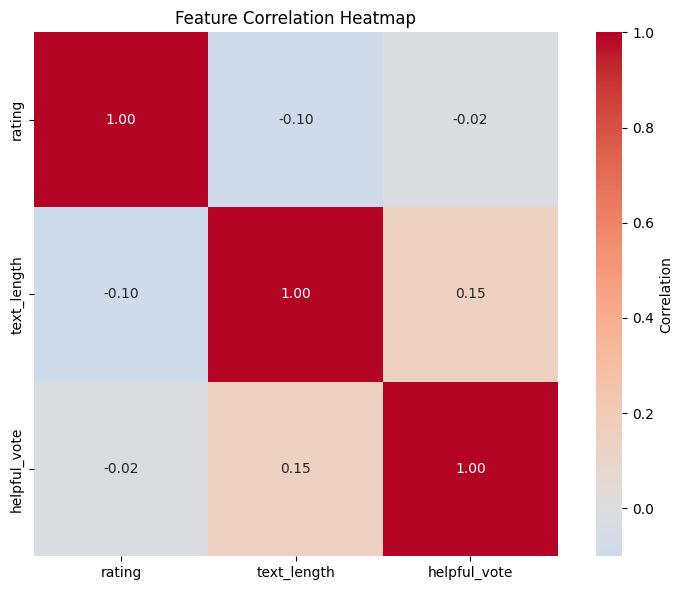

In [5]:
# Review text analysis
df['text_length'] = df['text'].apply(lambda x: len(x.split()) if pd.notna(x) else 0)
print(f"\nReview length stats (words):\n{df['text_length'].describe()}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['text_length'], bins=50, color='coral', edgecolor='black', alpha=0.7)
plt.xlabel('Words in review')
plt.ylabel('Count')
plt.title('Review Length Distribution')
plt.xlim(0, df['text_length'].quantile(0.95))

plt.subplot(1, 2, 2)
avg_length_by_rating = df.groupby('rating')['text_length'].mean()
plt.bar(avg_length_by_rating.index, avg_length_by_rating.values, color='salmon', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Avg Words in Review')
plt.title('Average Review Length by Rating')

plt.tight_layout()
plt.show()

# User and product statistics
n_users = df['user_id'].nunique()
n_products = df['asin'].nunique()

print(f"\n{n_users:,} unique users")
print(f"{n_products:,} unique products")
print(f"Avg reviews per user: {len(df)/n_users:.2f}")
print(f"Avg reviews per product: {len(df)/n_products:.2f}")

# Sparsity analysis
user_counts = df['user_id'].value_counts()
product_counts = df['asin'].value_counts()

print(f"\nUsers with only 1 review: {(user_counts == 1).sum():,} ({(user_counts == 1).sum()/n_users*100:.1f}%)")
print(f"Products with only 1 review: {(product_counts == 1).sum():,} ({(product_counts == 1).sum()/n_products*100:.1f}%)")

print(f"\nTop 10 most reviewed products:")
print(product_counts.head(10))

# Temporal trends
if 'timestamp' in df.columns:
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['year'] = df['date'].dt.year
    
    yearly = df['year'].value_counts().sort_index()
    print(f"\nReviews by year:")
    print(yearly)
    
    plt.figure(figsize=(10, 5))
    plt.plot(yearly.index, yearly.values, marker='o', linewidth=2, markersize=8)
    plt.xlabel('Year')
    plt.ylabel('Reviews')
    plt.title('Reviews Over Time')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Helpfulness
if 'helpful_vote' in df.columns:
    print(f"\nHelpful votes by rating:")
    print(df.groupby('rating')['helpful_vote'].mean().round(2))

# Correlation heatmap
numeric_cols = ['rating', 'text_length']
if 'helpful_vote' in df.columns:
    numeric_cols.append('helpful_vote')

corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

- Metadata Analysis

In [6]:
# Load metadata
meta_file = "meta_Home_and_Kitchen.jsonl.gz"
metadata = []

with gzip.open(meta_file, "rt", encoding="utf-8") as fp:
    for i, line in enumerate(fp):
        metadata.append(json.loads(line))
        if i >= 50000:  
            break

meta_df = pd.DataFrame(metadata)
meta_df.head()

print(f"\nLoaded {len(meta_df):,} products")
print(f"Columns: {list(meta_df.columns)}")
print(f"\nData types:\n{meta_df.dtypes}")
print(f"\nMissing values:\n{meta_df.isnull().sum()}")


Loaded 50,001 products
Columns: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together']

Data types:
main_category       object
title               object
average_rating     float64
rating_number        int64
features            object
description         object
price              float64
images              object
videos              object
store               object
categories          object
details             object
parent_asin         object
bought_together     object
dtype: object

Missing values:
main_category       1289
title                  0
average_rating         0
rating_number          0
features               0
description            0
price              24588
images                 0
videos                 0
store                872
categories             0
details                0
parent_asin            0
bought_together    50001
dtype: in

Metadata columns: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together', 'price_clean']

Price statistics:
count    25413.000000
mean        52.260023
std        132.257010
min          0.260000
25%         14.210000
50%         22.990000
75%         42.990000
max       4289.000000
Name: price_clean, dtype: float64


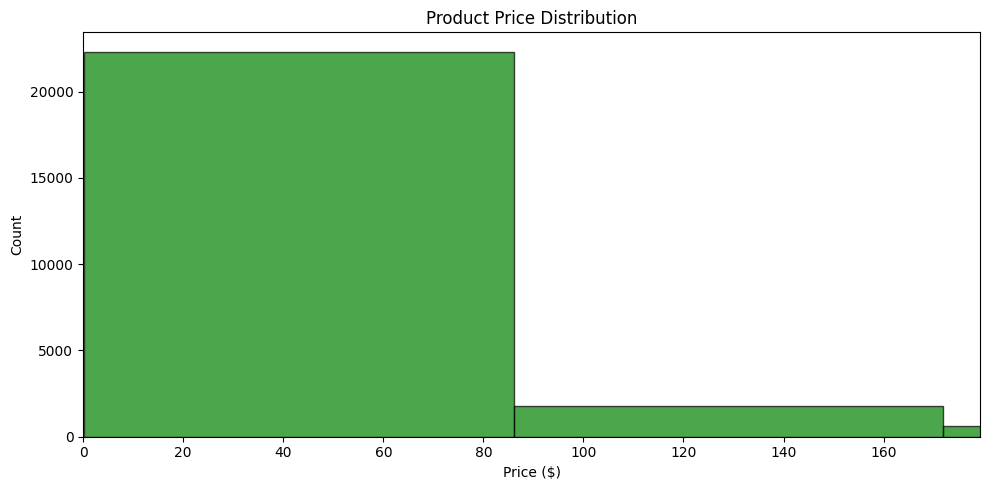


Merged 8,923 products with review data


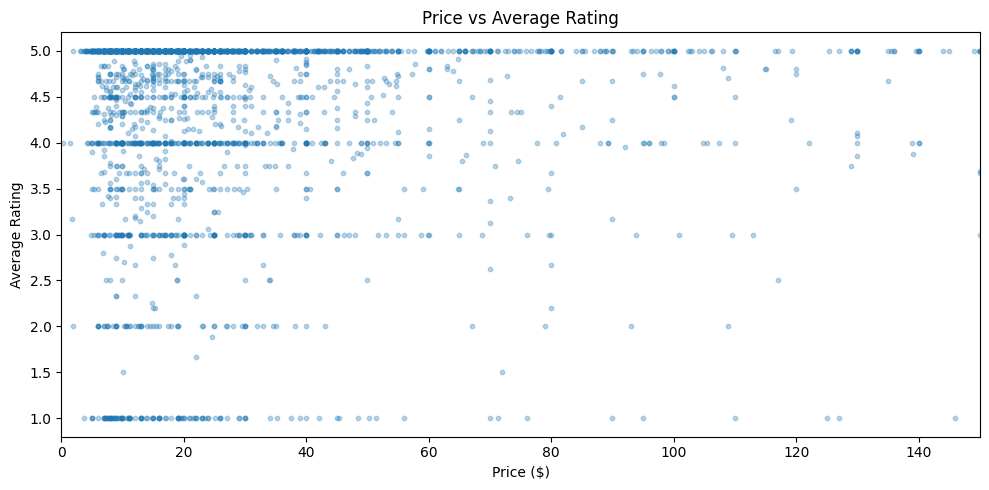

In [15]:
print(f"Metadata columns: {list(meta_df.columns)}")

# Price analysis
if 'price' in meta_df.columns:
    meta_df['price_clean'] = pd.to_numeric(meta_df['price'], errors='coerce')
    print(f"\nPrice statistics:")
    print(meta_df['price_clean'].describe())
    
    plt.figure(figsize=(10, 5))
    plt.hist(meta_df['price_clean'].dropna(), bins=50, color='green', edgecolor='black', alpha=0.7)
    plt.xlabel('Price ($)')
    plt.ylabel('Count')
    plt.title('Product Price Distribution')
    plt.xlim(0, meta_df['price_clean'].quantile(0.95))
    plt.tight_layout()
    plt.show()

# Category analysis
if 'categories' in meta_df.columns:
    all_categories = []
    for cats in meta_df['categories'].dropna():
        if isinstance(cats, list):
            for cat_list in cats:
                if isinstance(cat_list, list):
                    all_categories.extend(cat_list)
    
    if len(all_categories) > 0:
        cat_counts = Counter(all_categories)
        top_cats = cat_counts.most_common(10)
        
        print(f"\nTop 10 categories:")
        for cat, count in top_cats:
            print(f"{cat}: {count:,}")
        
        plt.figure(figsize=(12, 6))
        cats, counts = zip(*top_cats)
        plt.barh(range(len(cats)), counts, color='purple', edgecolor='black')
        plt.yticks(range(len(cats)), cats)
        plt.xlabel('Number of Products')
        plt.title('Top Product Categories')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

elif 'main_category' in meta_df.columns:
    print(f"\nTop categories:")
    print(meta_df['main_category'].value_counts().head(10))

# Brand analysis  
if 'brand' in meta_df.columns:
    print(f"\nTop 10 brands:")
    print(meta_df['brand'].value_counts().head(10))

# Merge with reviews
product_id_col = 'parent_asin' if 'parent_asin' in meta_df.columns else 'asin'

if product_id_col in meta_df.columns:
    product_stats = df.groupby('asin').agg({
        'rating': 'mean',
        'text_length': 'mean'
    }).reset_index()
    product_stats.columns = ['asin', 'avg_rating', 'avg_text_length']
    
    merged = meta_df.merge(product_stats, left_on=product_id_col, right_on='asin', how='inner')
    print(f"\nMerged {len(merged):,} products with review data")
    
    # Price vs rating
    if 'price_clean' in merged.columns:
        plt.figure(figsize=(10, 5))
        plt.scatter(merged['price_clean'], merged['avg_rating'], alpha=0.3, s=10)
        plt.xlabel('Price ($)')
        plt.ylabel('Average Rating')
        plt.title('Price vs Average Rating')
        plt.xlim(0, merged['price_clean'].quantile(0.95))
        plt.tight_layout()
        plt.show()

Part 3 - Rating Prediction
-> What will a user rate a given item based on their past reviews?